In [19]:
# Import relevant modules
import cv2
import numpy as np
from matplotlib import pyplot as plt
from helper_functions.utils import *

TRAIN_IMGS_DIR = "../data/train"


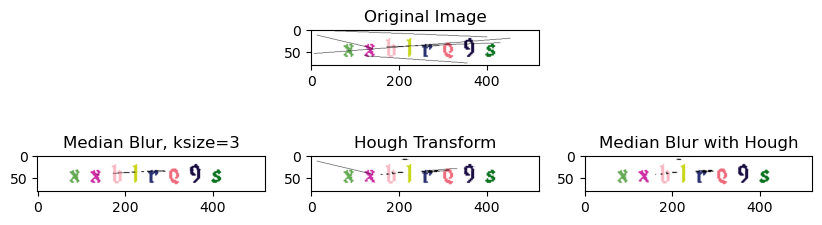

In [20]:
"""
Experiment with denoising
"""
img = get_random_train_img(TRAIN_IMGS_DIR)

"""Median blur"""
medianBlur = cv2.medianBlur(img, 3)

"""Hough transform"""
houghTransform = img.copy()
grayImg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
binary = cv2.adaptiveThreshold(grayImg, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
edges = cv2.Canny(binary, 50, 150)
lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi/180, threshold=100, minLineLength=75, maxLineGap=10)
# Remove lines by drawing over them
mask = np.zeros_like(grayImg)
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(mask, (x1, y1), (x2, y2), 255, 2)  # Draw white lines on black mask
cleaned = cv2.inpaint(img, mask, inpaintRadius=1, flags=cv2.INPAINT_TELEA)
medianBlurHough = cv2.medianBlur(cleaned, 3)


plt.figure(figsize=(10, 3))
imshow(img, "Original Image", 232)
imshow(medianBlur, "Median Blur, ksize=3", 234)
imshow(cleaned, "Hough Transform", 235)
imshow(medianBlurHough, "Median Blur with Hough", 236)


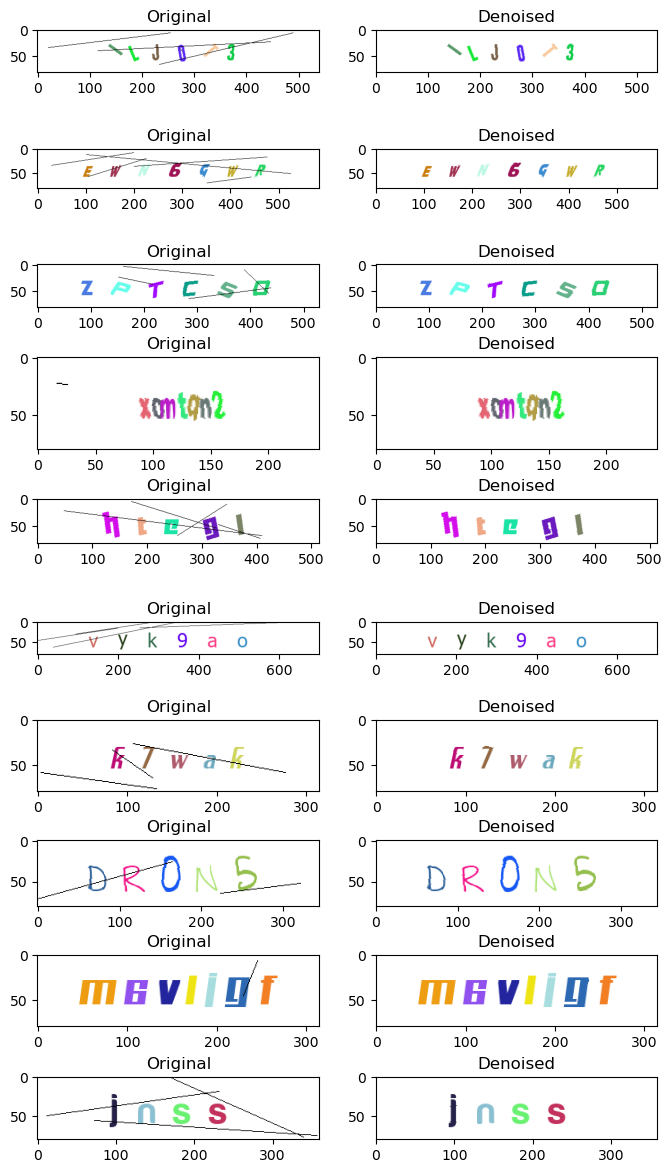

In [21]:
"""
FINAL DENOISING METHOD: replace black with median
"""

# Replace all black lines with white
def replace_black_with_median(image, kernel_size=5):
    """
    Replaces all black pixels in an image with the median of their local neighborhood.
    
    :param image: Input image (grayscale or color)
    :param kernel_size: Size of the patch used for computing the median
    :return: Image with black pixels replaced by median values
    """
    # Convert to grayscale if the image is colored
    is_color = len(image.shape) == 3
    
    # Define black pixel condition
    if is_color:
        black_pixels = np.all(image == [0, 0, 0], axis=-1)  # Mask for black pixels
    else:
        black_pixels = (image == 0)  # Grayscale mask

    # Compute median blur (preserves edges better than Gaussian blur)
    median_filtered = cv2.medianBlur(image, kernel_size)
    
    # Replace black pixels with median values
    image[black_pixels] = median_filtered[black_pixels]

    return image


# Apply function
NUM_IMGS = 10
imgs = get_n_random_train_imgs(TRAIN_IMGS_DIR, NUM_IMGS)
denoised_imgs = [replace_black_with_median(img.copy()) for img in imgs]

fig, axes = plt.subplots(nrows=NUM_IMGS, ncols=2, figsize=(8, NUM_IMGS*1.5))

for i, (orig, denoised) in enumerate(zip(imgs, denoised_imgs)):
    axes[i, 0].imshow(orig), axes[i, 0].set_title("Original")
    axes[i, 1].imshow(denoised), axes[i, 1].set_title("Denoised")

